# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [30]:
import pandas as pd
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

testing and working around woth models and scikitlearn to find optimal

In [48]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load data
df = pd.read_csv("C:/Users/nikhi/Downloads/customer_booking.csv", encoding="ISO-8859-1")

# Step 2: Explore and preprocess
# print(df.info())  # Check data types
# print(df.isnull().sum())  # Check for null values

# Step 3: Define features and target

X = df.drop(columns=["booking_complete","wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals"], axis=1)
y = df["booking_complete"]

# Step 4: Convert categorical columns (if any)
X = pd.get_dummies(X, drop_first=True)

# Step 5: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model=LogisticRegression(max_iter=3000).fit(X_train,y_train)

# Step 6: Scale data (important for Logistic Regression)

pipe=Pipeline(
   [("scaler",StandardScaler()),
    ("model",LogisticRegression())]
)



mod= GridSearchCV(estimator=pipe,param_grid={"verbose":[True,False]},cv=3)
mod.fit(X_train,y_train)
y_pred=mod.predict(X_test)

print(accuracy_score(y_pred,y_test))

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Step 7: Train model
# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Step 8: Evaluate
# y_pred = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# from sklearn.metrics import roc_curve, auc

# y_scores = model.predict_proba(X_test)[:, 1]  # get probability for class 1
# fpr, tpr, thresholds = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # random guess line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.3s
0.8498
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.45      0.07      0.12      1480

    accuracy                           0.85     10000
   macro avg       0.65      0.53      0.52     10000
weighted avg       0.80      0.85      0.80     10000



Accuracy: 0.8516
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8520
           1       0.49      0.09      0.15      1480

    accuracy                           0.85     10000
   macro avg       0.68      0.54      0.53     10000
weighted avg       0.81      0.85      0.81     10000



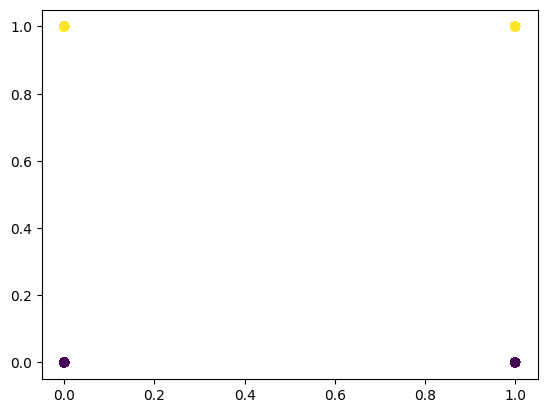

In [ ]:
df = pd.read_csv("C:/Users/nikhi/Downloads/customer_booking.csv", encoding="ISO-8859-1")
df.head()

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [ ]:
complete_booking=df[df['booking_complete']==1]
complete_booking.head()
not_complete_booking=df[df['booking_complete']==0]
not_complete_booking.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df['booking_complete'].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [ ]:
df['booking_origin'].value_counts()

booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Ghana                       1
Gibraltar                   1
Guatemala                   1
Algeria                     1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

In [ ]:
complete_booking['booking_origin'].value_counts()

booking_origin
Malaysia                2468
Australia                900
China                    694
Indonesia                615
Japan                    478
Thailand                 470
South Korea              462
Singapore                299
Taiwan                   224
India                    131
Vietnam                  114
Macau                     95
United States             84
Philippines               75
Hong Kong                 73
New Zealand               54
Brunei                    41
Cambodia                  36
United Kingdom            21
(not set)                 14
France                    14
Myanmar (Burma)           13
Germany                   12
Italy                     11
Saudi Arabia              11
Laos                       6
Sweden                     5
Qatar                      5
Mauritius                  4
Bahrain                    3
Switzerland                3
Denmark                    3
Russia                     3
Nepal                      3

In [ ]:
df['flight_duration'].value_counts()

flight_duration
8.83    14520
8.58     6965
5.62     5524
6.62     4721
7.00     3374
7.57     2835
4.67     2743
6.42     1737
5.33     1554
4.75     1255
6.33     1190
8.67      807
5.52      667
5.07      512
4.72      502
8.15      311
5.00      241
7.42      224
4.83      156
5.13      125
9.50       37
Name: count, dtype: int64

In [ ]:
complete_booking['flight_duration'].value_counts()

flight_duration
8.83    1688
6.62     810
7.00     738
4.67     675
8.58     542
5.62     525
7.57     500
4.75     419
5.33     386
6.42     372
6.33     195
8.67     189
5.07     121
4.72     121
5.00      58
5.52      52
7.42      34
5.13      28
4.83      19
9.50       5
8.15       1
Name: count, dtype: int64

In [ ]:
complete_booking['num_passengers'].value_counts()

num_passengers
1    4455
2    2051
3     491
4     275
5     109
6      54
7      18
9      13
8      12
Name: count, dtype: int64

In [ ]:
complete_booking['purchase_lead'].value_counts()

purchase_lead
7      122
4      121
2      120
6      118
13     117
      ... 
381      1
354      1
417      1
867      1
390      1
Name: count, Length: 424, dtype: int64

In [ ]:
complete_booking['route'].value_counts()

route
AKLKUL    567
PENTPE    401
DMKKIX    187
JHBKTM    164
MELPEN    137
         ... 
AKLPVG      1
MELNRT      1
MELMLE      1
NRTSYD      1
OOLUTP      1
Name: count, Length: 549, dtype: int64

In [ ]:
complete_booking['sales_channel'].value_counts()

sales_channel
Internet    6869
Mobile       609
Name: count, dtype: int64

In [ ]:
complete_booking['trip_type'].value_counts()

trip_type
RoundTrip     7453
OneWay          20
CircleTrip       5
Name: count, dtype: int64

In [ ]:
complete_booking['flight_hour'].value_counts()


flight_hour
9     508
13    503
14    489
6     488
8     484
12    460
5     431
4     430
7     423
10    415
11    407
3     393
2     389
15    376
16    297
1     285
0     182
17    167
23    103
18     85
22     54
21     45
19     39
20     25
Name: count, dtype: int64

In [ ]:
complete_booking['length_of_stay'].value_counts()

length_of_stay
6      1613
5      1370
4      1039
3       506
17      197
       ... 
289       1
116       1
119       1
365       1
132       1
Name: count, Length: 180, dtype: int64

In [ ]:
complete_booking['wants_extra_baggage'].value_counts()


wants_extra_baggage
1    5573
0    1905
Name: count, dtype: int64

In [ ]:
complete_booking['wants_in_flight_meals'].value_counts()

wants_in_flight_meals
0    4050
1    3428
Name: count, dtype: int64

In [ ]:
complete_booking['wants_preferred_seat'].value_counts()

wants_preferred_seat
0    4849
1    2629
Name: count, dtype: int64